# Audio to Vinyl
================

This code unpacks and repacks data from *16 bit stereo wav file at 44100hz sampling rate* to *16 bit mono wav file at 44100hz sampling rate*

Inspiration from and code starting point from https://www.instructables.com/Laser-Cut-Record/.  I set out to make this more 'push button' than the original instructables.

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install ezdxf

In [2]:
#imports
from scipy.io import wavfile
import math

import torch
import torchaudio

import ezdxf
from ezdxf.addons.drawing import Frontend, RenderContext, dxf, svg, layout, config, matplotlib
from ezdxf.gfxattribs import GfxAttribs

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# Configuration

In [3]:
# FILE SETTINGS
fileName = "frequency_sweep.wav" #file to be imported (change this)
# fileName = "07 - Around The World.mp3";

In [4]:
# CALCULATION OPTIONS
samplingRate = 44100 #sampling rate of incoming audio
rpm = 45.0 #33.3,45,78
amplitude = 10 #in pixels
minDist = 6.0 #min pixel spacing between points in vector path (to prevent cutter from stalling)
spacing = 10 #space between grooves (in pixels)

In [5]:
# OUTPUT OPTIONS
display_plots = True #Rendering the intermediate waveform plots takes time, turn these off for faster processing
save_audio = True #Save the intermediate and final audio transforms

cutlines = True #cut the inner and outer perimeters
label = True #render the label

innerHole = 0.286 #diameter of center hole in inches
diameter = 7 # 11.8 #diameter of record in inches
outerRad = 6.8 / 2 #5.75 #radius of outermost groove in inches
innerRad = 2.25 #radius of innermost groove in inches
labelRad = 2 #radius of the label

In [6]:
# LASER OPTIONS
# dpi of cutter; change this to tune how close the groves are to eachother
dpi = 1200 
# > many lasers will choke if you send them all the data at once, this number spits the cutting path into several files that
# > can be sent to the laser cutter in series, decrease this number to lower the amount of data on each section
numGroovesPerFile = 20 
# > You will have to choose the cutoff frequency according to the max sampling rate that you can get with your cutter.  
# > For example, my laser cutter melts anything above 2.5kHz at 45rpm, so I set my anti-aliasing filter cutoff to this same frequency.  
# > Set the drop off as high as possible, for me this was 48dB/octave, that way the filter will have a hard cutoff.
cutoff_freq = 2500
# > amplify the signal as much as you can without noticeable effects of clipping (you will be able to get away with some clipping, 
# > and remember this is not crystal clear audio anyway).
gain_db = -1.0

In [7]:
# CONSTANTS
SCALE_NUM = 25.4 #scale factor of vectors.  Our settings are in inches, but ezdxf works in mm
SEC_PER_MINUTE = 60
THETA_COUNT = 5880 #how many values of theta per cycle

# Process Audio Data

## Helper utility

In [8]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
   waveform = waveform.numpy()
   num_channels, num_frames = waveform.shape
   time_axis = torch.arange(0, num_frames) / sample_rate

   figure, axes = plt.subplots(num_channels, 1)
   if num_channels == 1:
       axes = [axes]
   for c in range(num_channels):
       axes[c].plot(time_axis, waveform[c], linewidth=1)
       axes[c].grid(True)
       if num_channels > 1:
           axes[c].set_ylabel(f"Channel {c+1}")
       if xlim:
           axes[c].set_xlim(xlim)
       if ylim:
           axes[c].set_ylim(ylim)
   figure.suptitle(title)
   plt.show(block=False)

## Load the File

In [9]:
# Load our audio file
file_path = Path(fileName)
waveform, sample_rate = torchaudio.load(file_path)
plot_waveform(waveform, sample_rate, title="Original") if display_plots else print("Skipping plot")

Skipping plot


## Stereo to Mono

In [10]:
# Convert stereo to mono (since we only are going to laser one channel)
waveform = torch.mean(waveform, dim=0).unsqueeze(0)
plot_waveform(waveform, sample_rate, title="Mono") if display_plots else print("Skipping plot")

Skipping plot


## RIAA Filter

In [11]:
# Apply the RIAA standard Vinyl filtering
waveform = torchaudio.functional.riaa_biquad(waveform, sample_rate)
plot_waveform(waveform, sample_rate, title="RIAA") if display_plots else print("Skipping plot")
torchaudio.save(file_path.with_stem(f"{file_path.stem}_riaa").with_suffix(".wav"), waveform, sample_rate) if save_audio else print("Skipping audio save")

Skipping plot


## Low pass filter

In [12]:
# Apply a low pass filter
waveform = torchaudio.functional.lowpass_biquad(waveform, sample_rate, cutoff_freq)
plot_waveform(waveform, sample_rate, title="Lowpass") if display_plots else print("Skipping plot")
torchaudio.save(file_path.with_stem(f"{file_path.stem}_lowpass").with_suffix(".wav"), waveform, sample_rate) if save_audio else print("Skipping audio save")

Skipping plot


# Amplification

In [13]:
# Apply amplifications
waveform = torchaudio.functional.gain(waveform, gain_db)
plot_waveform(waveform, sample_rate, title="Gain") if display_plots else print("Skipping plot")
torchaudio.save(file_path.with_stem(f"{file_path.stem}_gain").with_suffix(".wav"), waveform, sample_rate) if save_audio else print("Skipping audio save")

Skipping plot


## Normalize audio data to given bitdepth

In [14]:
# Recalcuate our variables based on scale pixel distances
amplitude_s =  amplitude / dpi * 72 #SCALE_NUM
print(f"Adjusted amplitue: {amplitude_s}")

vol = torchaudio.transforms.Vol(gain=amplitude_s)
waveform = vol(waveform)
plot_waveform(waveform, sample_rate, title="Normalized to the adjusted gain") if display_plots else print("Skipping plot")
torchaudio.save(file_path.with_stem(f"{file_path.stem}_waveform").with_suffix(".wav"), waveform, sample_rate) if save_audio else print("Skipping audio save")

Adjusted amplitue: 0.6
Skipping plot


# Vector Data Generation

## Precalcualte values needed for the vector transform

In [15]:
#We are done with Pytorch, so convert to numpy for the the vector stuff
audio_data = waveform.detach().cpu().numpy()[0]
length = len(audio_data) / sample_rate
print(f"length = {length}s")

# Recalculate some configuration based on the scale
minDist_s =  minDist / dpi * SCALE_NUM
print(f"Adjusted minDist: {minDist_s}")
spacing_s =  spacing / dpi * SCALE_NUM
print(f"Adjusted spacing: {spacing_s}")

# Additional calculations
incr_num = 2 * math.pi / THETA_COUNT #calculcate angular inrementation amount
print(f"incr_num = {incr_num} = (2 * {math.pi}) / {THETA_COUNT}")
rad_incr_num = (2 * amplitude_s + spacing_s) / THETA_COUNT #radial incrementation amount
print(f"rad_incr_num = {rad_incr_num} = {outerRad} * {SCALE_NUM}")
radius = outerRad * SCALE_NUM # calculate outermost radius
print(f"radius = {radius} = {outerRad} * {SCALE_NUM}")

# Calcuate our origin, which is the center of the record
x_orig = diameter / 2 * SCALE_NUM
y_orig = diameter / 2 * SCALE_NUM

length = 27.994285714285713s
Adjusted minDist: 0.127
Adjusted spacing: 0.21166666666666664
incr_num = 0.0010685689297924466 = (2 * 3.141592653589793) / 5880
rad_incr_num = 0.00024007936507936507 = 3.4 * 25.4
radius = 86.36 = 3.4 * 25.4


## DXF Document Initialization

In [16]:
# Init our ezdxf document
doc = ezdxf.new("R2010", setup=True)
doc.units = ezdxf.units.IN

#configure our layout
layout_setup = doc.page_setup("Layout1", "ISO A0", landscape=True)
page_setup = layout_setup.page_setup(size=(diameter, diameter), units="inch", margins=(0,0,0,0))

# Create our model space for our drawing entities
msp = doc.modelspace()

# Add our layers ahead of time.  This is here for convinence.  If we rerun notebook cells, then we get duplicate layer errors
# We should inherit dxf properties (like color) from the layer
outer_grove_layer = doc.layers.add(name="outer_grove", color=ezdxf.colors.CYAN, lineweight=5)
audio_layer = doc.layers.add("audio", color=ezdxf.colors.BLUE)
# audio_layer.off() # temporarily hide the rendering of the audio data (this helps troubleshoot the inner groves)
inner_grove_layer = doc.layers.add(name="inner_grove", color=ezdxf.colors.MAGENTA)
cutline_layer = doc.layers.add("cut_lines", color=ezdxf.colors.RED)
label_layer = doc.layers.add(name="label", color=ezdxf.colors.GREEN)

In [17]:
class Revolution:
    def __init__(self, radius):
        self.vertices = []
        self.end_radius = radius

# Calculate a path one revolution around the disk at the specified radius with the specified change in radius per increment
def calc_revolution(rad, rad_dec, start = None):
    # Set up our object to return
    rev = Revolution(rad)
    # add the start vertex if specified
    if start:
        rev.vertices.append(start) 
    
    xValLast = 0
    yValLast = 0
    for theta in np.arange(0, 2 * math.pi, incr_num): #for theta between 0 and 2pi
        #calculate new point
        radCalc = rev.end_radius
        xVal = x_orig + radCalc * math.cos(theta)
        yVal = y_orig - radCalc * math.sin(theta)
        if (xValLast-xVal)**2 + (yValLast-yVal)**2 > minDist**2:
            rev.vertices.append((xVal,yVal))
            # store last coordinates in vector path
            xValLast = xVal
            yValLast = yVal
        rev.end_radius -= rad_dec # decreasing radius forms spiral if not 0
    return rev

## Silent outer groove

In [18]:
print(f"Creating the silent outer groove: incr_num={incr_num}, radius={radius}")

outer_grove_rev = calc_revolution(radius, rad_incr_num)
outer_grove = msp.add_lwpolyline(
    outer_grove_rev.vertices,
    dxfattribs=GfxAttribs(layer=outer_grove_layer.dxf.name)
)
# outer_grove.dxf.layer = outer_grove_layer.dxf.name #set the layer.  

radius = outer_grove_rev.end_radius #update our current radius tracker

Creating the silent outer groove: incr_num=0.0010685689297924466, radius=86.36


## Draw the audio line(s)

In [19]:
numGrooves = 1;
index = 0;
indexIncr = int(samplingRate * SEC_PER_MINUTE / rpm / THETA_COUNT)
print(f"Index Incr: {samplingRate} * {SEC_PER_MINUTE} / {rpm} / {THETA_COUNT} = {indexIncr}")

# loop while we are still inside the radius of the disk and we still have audio to process
print(f"Creating the audio lines: indexIncr={indexIncr}, radius={radius}, innerRad={innerRad}, rad_incr_num={rad_incr_num}") 
xValLast = 0; 
yValLast = 0;
audio_grove_vertices = [outer_grove_rev.vertices[-1]] # start at the last 'rendered' point
while radius > innerRad * SCALE_NUM and index < len(audio_data) - (THETA_COUNT * indexIncr):
    # print(f"{radius} > {innerRad * SCALE_NUM} and {index} < {len(audio_data)} - {incr_num * indexIncr}")
    # loop once around the disk
    for theta in np.arange(0, 2 * math.pi, incr_num): #for theta between 0 and 2pi
        # calculate the next point in the audio line
        radCalc = radius + audio_data[index]
        index += indexIncr # go to next spot in audio data
        xVal = x_orig + radCalc * math.cos(theta)
        yVal = y_orig - radCalc * math.sin(theta)
        if (xValLast-xVal)**2 + (yValLast-yVal)**2 > minDist**2:
            audio_grove_vertices.append((xVal,yVal))
            # store last coordinates in vector path
            xValLast = xVal
            yValLast = yVal
        radius -= rad_incr_num # decreasing radius forms spiral

    # Handle the splitting of the audio track
    numGrooves += 1
    if numGrooves % numGroovesPerFile == 0:
        print(f"Spliting track ({numGrooves / numGroovesPerFile}): max grooves per line reached")
        # time to splt the track
        audio_grove = msp.add_lwpolyline(audio_grove_vertices) # write what we have so far
        audio_grove.dxf.layer = audio_layer.dxf.name
        audio_grove_vertices = [] # reset our data
        audio_grove_vertices.append((xValLast, yValLast)) # add the last vertex so we have a continuous track

audio_grove = msp.add_lwpolyline(audio_grove_vertices) #Note the returned reference is only the last written track
audio_grove.dxf.layer = audio_layer.dxf.name

Index Incr: 44100 * 60 / 45.0 / 5880 = 10
Creating the audio lines: indexIncr=10, radius=84.9483333333004, innerRad=2.25, rad_incr_num=0.00024007936507936507
Spliting track (1.0): max grooves per line reached


## Draw silent inner locked groove

In [20]:
print(f"Creating the silent inner groove: incr_num={incr_num}, radius={radius}")
inner_grove_rev = calc_revolution(radius, rad_incr_num, audio_grove_vertices[-1])
inner_grove = msp.add_lwpolyline(inner_grove_rev.vertices)
inner_grove.dxf.layer = inner_grove_layer.dxf.name
radius = inner_grove_rev.end_radius

print(f"Creating the silent inner locked groove: incr_num={incr_num}, radius={radius}")
inner_grove2 = msp.add_circle((x_orig, y_orig), radius) #closed, so just draw it as a circle
inner_grove2.dxf.layer = inner_grove_layer.dxf.name

Creating the silent inner groove: incr_num=0.0010685689297924466, radius=56.71499999952396
Creating the silent inner locked groove: incr_num=0.0010685689297924466, radius=55.30333333286614


In [21]:
# Sanity check
if radius < labelRad * SCALE_NUM:
    print(f"WARNING: Your audio radius {radius} has crashed into your label radius {labelRad * SCALE_NUM}")

## Add the cutlines

In [22]:
# Generate the cut lines 
if cutlines:
    # Center Hole
    print(f"Adding Center Hole at: {(x_orig, y_orig)} and radius={innerHole / 2 * SCALE_NUM}")
    inner_hole_circle = msp.add_circle((x_orig, y_orig), innerHole / 2 * SCALE_NUM) 
    inner_hole_circle.dxf.layer = cutline_layer.dxf.name

    # Outer edge
    print(f"Adding Outer Edge at: {(x_orig, y_orig)} and radius={diameter / 2 * SCALE_NUM}")
    outer_edge_circle = msp.add_circle((x_orig, y_orig), diameter / 2 * SCALE_NUM) 
    outer_edge_circle.dxf.layer = cutline_layer.dxf.name


Adding Center Hole at: (88.89999999999999, 88.89999999999999) and radius=3.6321999999999997
Adding Outer Edge at: (88.89999999999999, 88.89999999999999) and radius=88.89999999999999


## Add a label to the disk

In [23]:
label_text = f'''
{file_path}
* Sampling Rate: {samplingRate} Hz
* RPM: {rpm}
* Amplitude: {amplitude} pixels
* DPI: {dpi}
* Cutoff Frequency: {cutoff_freq} Hz 
* Gain: {gain_db} Db
'''

if label:
    # Label edge
    print(f"Adding label Edge at: {(x_orig, y_orig)} and radius={labelRad * SCALE_NUM}")
    label_edge_circle = msp.add_circle((x_orig, y_orig), labelRad * SCALE_NUM) 
    label_edge_circle.dxf.layer = label_layer.dxf.name

    # Add the file name
    print(f"Adding label text at: ({x_orig} + (2*{labelRad}/3 * {SCALE_NUM} * {math.cos(90+45)}), {y_orig} - (2{labelRad}/3 * {SCALE_NUM} * {math.cos(90+45)}))")
    label_file = msp.add_mtext(label_text)
    label_file.set_location((x_orig + (2*labelRad/3 * SCALE_NUM * math.cos(90+45)), y_orig - (2*labelRad/3 * SCALE_NUM * math.cos(90+45)))) # put it at a 45 deg angle top left from the origin

Adding label Edge at: (88.89999999999999, 88.89999999999999) and radius=50.8
Adding label text at: (88.89999999999999 + (2*2/3 * 25.4 * -0.9960878351411849), 88.89999999999999 - (22/3 * 25.4 * -0.9960878351411849))


# Export our results

In [24]:
# Create some shared export resources

# Create the render context
context = RenderContext(doc)

# Create a page layout, should be the size of the record
page = layout.Page(diameter, diameter,
                   layout.Units.inch,
                   margins=layout.Margins.all(0))

# Set up our export options
cfg = config.Configuration(
    background_policy=config.BackgroundPolicy.OFF, # transparent background
    color_policy=config.ColorPolicy.COLOR, # use the dxf specified colors
    hatch_policy=config.HatchPolicy.IGNORE, # don't use a fill for our entities
    line_policy=config.LinePolicy.ACCURATE, # follow the DXF properties accurately
    lineweight_policy=config.LineweightPolicy.ABSOLUTE, # convert DXF properties to mm
)

## PNG Export

This is really just for reference.  The JPEG isn't usable by the laser cutter.

See https://ezdxf.mozman.at/docs/addons/drawing.html#ezdxf.addons.drawing.matplotlib.qsave for export details

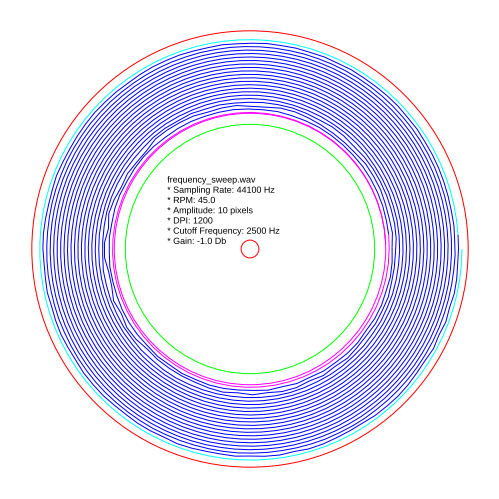

In [25]:
# Create our matplotlib figure
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

# Create the backend
plt_backend = matplotlib.MatplotlibBackend(ax)
# Create the frontend
plt_frontend = Frontend(context, plt_backend, config=cfg)

# I like to do drarwings
plt_frontend.draw_layout(msp, finalize=True)

# Render to PNG
fig.savefig(file_path.with_suffix(".png"), dpi=72)  # TODO - derive the DPI so this scales correctly

## SVG Export

This will work for laser cutting.

See https://ezdxf.readthedocs.io/en/stable/tutorials/image_export.html#id8 export for details

In [26]:
# Create the backend and frontend
svg_backend = svg.SVGBackend()
svg_frontend = Frontend(context, svg_backend, config=cfg)

# I like to do drawrings
svg_frontend.draw_layout(msp)

# Get the SVG rendering as string and write it to a file
svg_string = svg_backend.get_string(page)
with open(file_path.with_suffix(".svg"), "wt", encoding="utf8") as fp:
    fp.write(svg_string)

## DXF Export

In [27]:
doc.saveas(file_path.with_suffix(".dxf"))